In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

%matplotlib inline



In [58]:
def load_latest_transformed_data():
    output_dir = 'output'
    if not os.path.exists(output_dir):
        print("FIND NOT FOUND : PLEASE RUN ETL ")
        return None
    
    csv_files = [f for f in os.listdir(output_dir) if f.startswith('transformed_data_') and f.endswith('.csv')]
    if not csv_files:
        print("FIND NOT FOUND : PLEASE RUN ETL ")
        return None
    
    latest_file = max(csv_files, key=lambda f: os.path.getmtime(os.path.join(output_dir, f)))
    filepath = os.path.join(output_dir, latest_file)
    
    df = pd.read_csv(filepath)
    
    return df

df = load_latest_transformed_data()
if df is not None:
    df.head()


In [59]:

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()


,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,NumberofSeats,PriceinGermany,PriceinUK,AveragePrice,RangePerPrice,EnergyEfficiency,Drive_encoded,SpeedCategory_encoded,RangeCategory_encoded,PriceCategory_encoded
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,7.625067,179.528302,355.687332,198.638814,518.113208,5.264151,61964.741240,40346.884097,51155.812668,16.139947,1.842275,0.824798,1.150943,1.218329,1.061995
std,3.166777,39.524691,116.689699,33.736643,247.754670,0.964384,43465.142505,41483.988762,38371.939587,76.139635,0.701202,0.773919,0.763256,0.934786,1.262317
min,2.100000,123.000000,95.000000,104.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.001213,0.536723,0.000000,0.000000,0.000000,0.000000
25%,5.100000,150.000000,265.000000,173.000000,310.000000,5.000000,39947.500000,0.000000,29452.500000,0.005948,1.408721,0.000000,1.000000,0.000000,0.000000
50%,7.300000,180.000000,355.000000,191.000000,480.000000,5.000000,54450.000000,36795.000000,42275.000000,0.007796,1.881443,1.000000,1.000000,1.000000,0.000000
75%,9.000000,200.000000,430.000000,217.500000,650.000000,5.000000,70505.000000,57500.000000,61431.250000,0.010278,2.189376,1.000000,2.000000,2.000000,2.000000
max,22.400000,410.000000,970.000000,295.000000,1240.000000,7.000000,400000.000000,350000.000000,375000.000000,525.000000,5.476190,2.000000,3.000000,3.000000,4.000000


In [60]:

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_df[missing_df['Missing Count'] > 0]


,Missing Count,Missing %
PriceCategory,18,4.851752


In [61]:

corr_matrix = df[numeric_cols].corr()
print("📊 Ma trận tương quan:")
corr_matrix


📊 Ma trận tương quan:


,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,NumberofSeats,PriceinGermany,PriceinUK,AveragePrice,RangePerPrice,EnergyEfficiency,Drive_encoded,SpeedCategory_encoded,RangeCategory_encoded,PriceCategory_encoded
Acceleration,1.000000,-0.833897,-0.742176,0.275884,-0.715344,0.418278,-0.493155,-0.495416,-0.547104,-0.018256,-0.678627,0.471798,0.492664,0.398495,-0.432216
TopSpeed,-0.833897,1.000000,0.766101,-0.133404,0.774595,-0.332460,0.665113,0.606375,0.704474,0.006451,0.667128,-0.431057,-0.425515,-0.309777,0.460873
Range,-0.742176,0.766101,1.000000,-0.187557,0.741398,-0.182465,0.528875,0.406471,0.519255,0.034322,0.915666,-0.310956,-0.466973,-0.279876,0.424016
Efficiency,0.275884,-0.133404,-0.187557,1.000000,-0.169456,0.713525,0.122362,0.056277,0.099722,0.024826,-0.512976,-0.216498,0.114641,0.020933,0.127455
FastChargeSpeed,-0.715344,0.774595,0.741398,-0.169456,1.000000,-0.267352,0.508150,0.475663,0.544919,0.041408,0.685519,-0.267147,-0.437982,-0.343877,0.467382
NumberofSeats,0.418278,-0.332460,-0.182465,0.713525,-0.267352,1.000000,-0.072414,-0.201047,-0.149689,0.001616,-0.357468,-0.031976,0.169665,0.151712,-0.042350
PriceinGermany,-0.493155,0.665113,0.528875,0.122362,0.508150,-0.072414,1.000000,0.632098,0.908048,-0.302885,0.409259,-0.445275,-0.143811,-0.123023,0.270081
PriceinUK,-0.495416,0.606375,0.406471,0.056277,0.475663,-0.201047,0.632098,1.000000,0.898550,-0.206648,0.279218,-0.296183,-0.282835,-0.290786,0.392468
AveragePrice,-0.547104,0.704474,0.519255,0.099722,0.544919,-0.149689,0.908048,0.898550,1.000000,-0.283248,0.382722,-0.412291,-0.234336,-0.226861,0.365114
RangePerPrice,-0.018256,0.006451,0.034322,0.024826,0.041408,0.001616,-0.302885,-0.206648,-0.283248,1.000000,0.026934,0.067140,-0.008760,-0.019809,0.494430


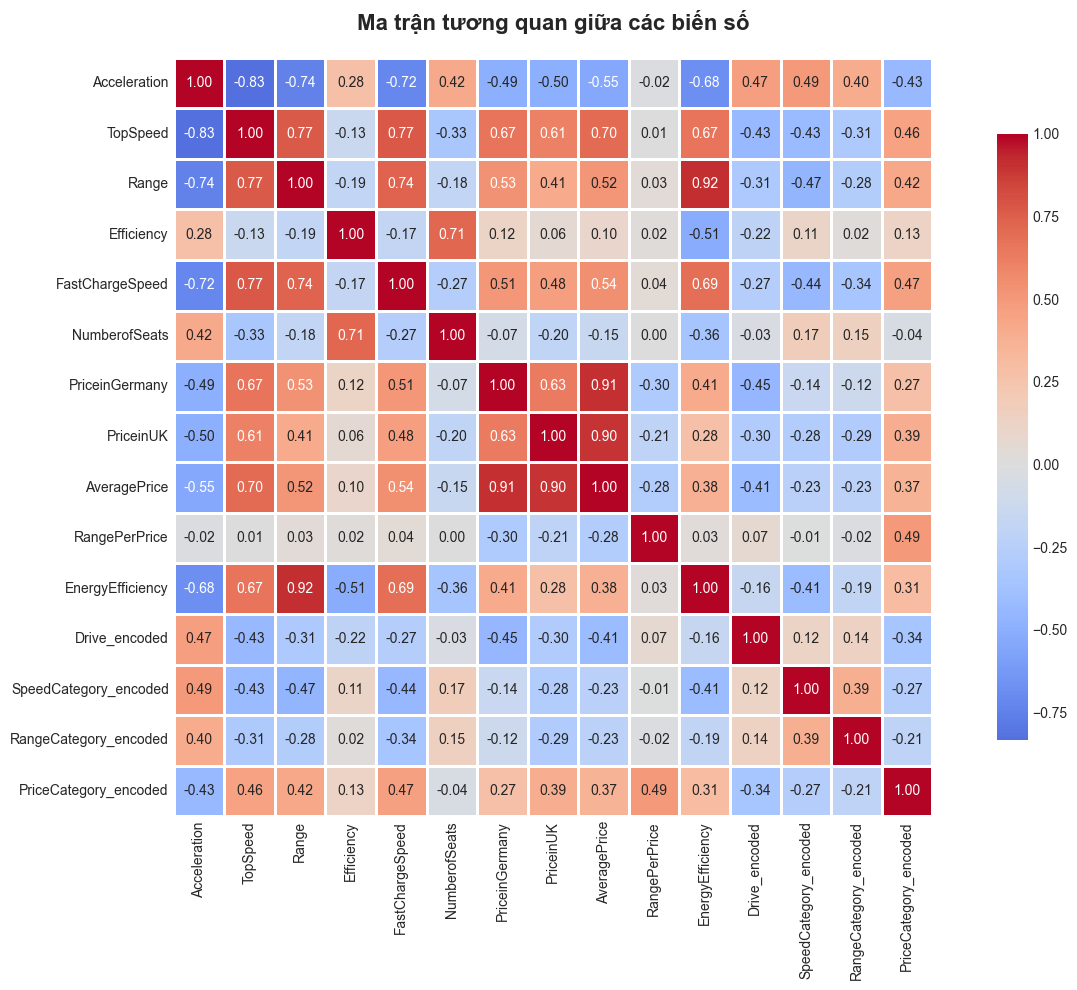

In [62]:

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận tương quan giữa các biến số', fontsize=16, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()


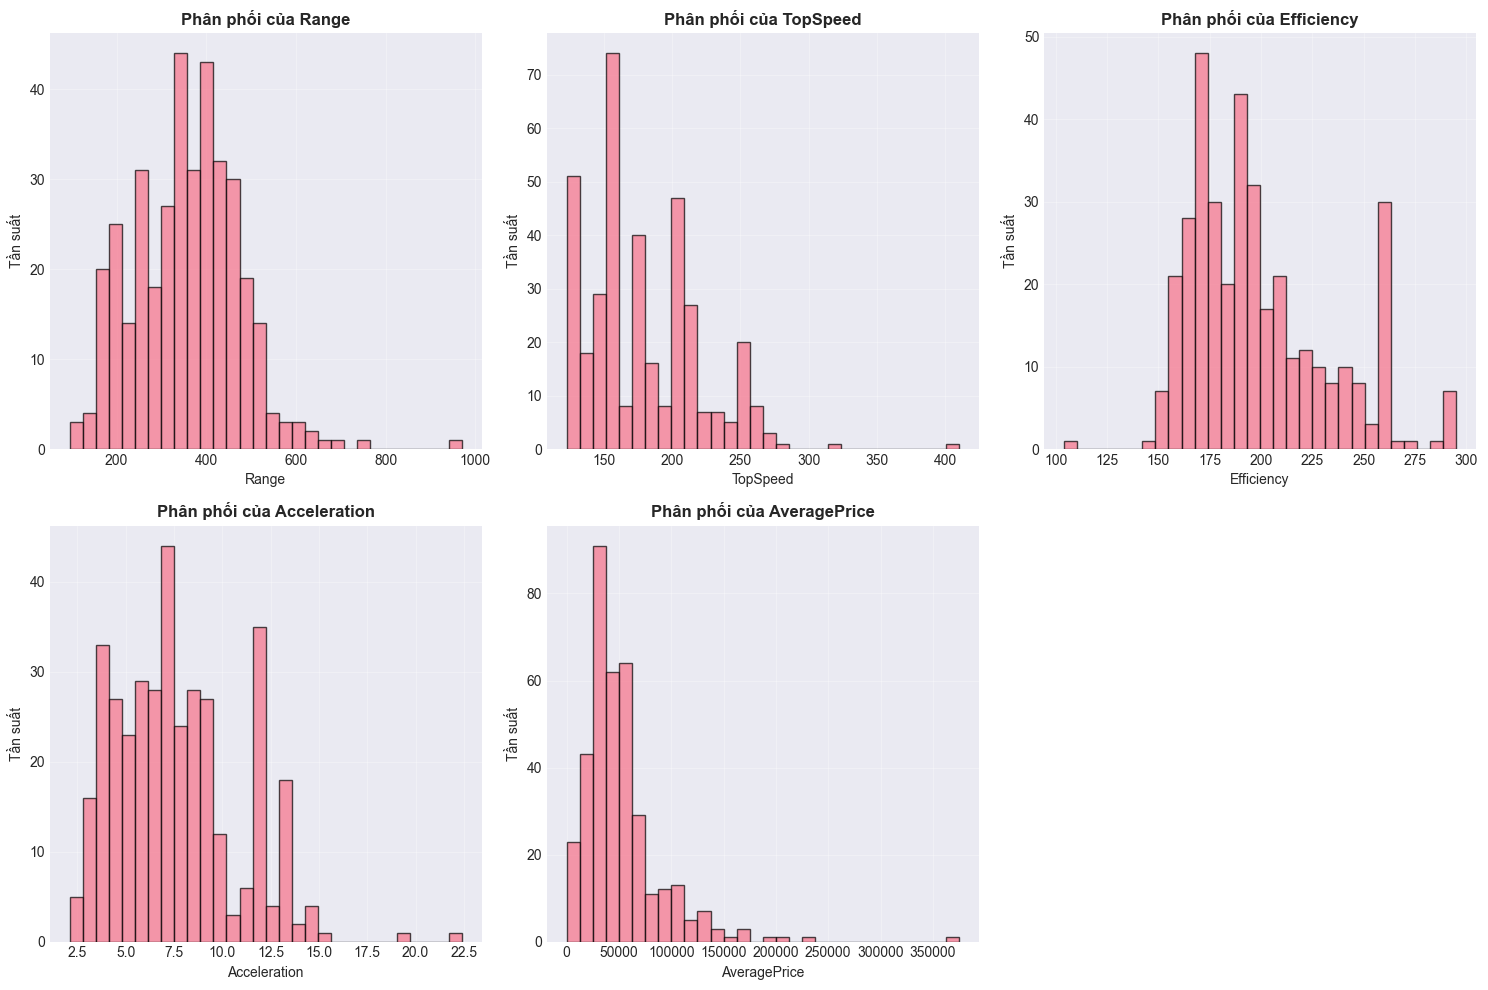

In [63]:

key_vars = ['Range', 'TopSpeed', 'Efficiency', 'Acceleration', 'AveragePrice']
available_vars = [v for v in key_vars if v in df.columns]

n_vars = len(available_vars)
fig, axes = plt.subplots(2, (n_vars + 1) // 2, figsize=(15, 10))
axes = axes.flatten() if n_vars > 1 else [axes]

for idx, var in enumerate(available_vars):
    ax = axes[idx]
    df[var].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Phân phối của {var}', fontsize=12, fontweight='bold')
    ax.set_xlabel(var)
    ax.set_ylabel('Tần suất')
    ax.grid(True, alpha=0.3)


for idx in range(len(available_vars), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


In [64]:

features = ['Range', 'TopSpeed', 'Efficiency', 'AveragePrice']
available_features = [f for f in features if f in df.columns]


X = df[available_features].dropna()
print(f" {len(X)}")


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_clustered = df.loc[X.index].copy()
df_clustered['Cluster'] = clusters

print(df_clustered['Cluster'].value_counts().sort_index())


 371
Cluster
0     64
1    156
2    106
3     45
Name: count, dtype: int64


In [65]:

cluster_stats = df_clustered.groupby('Cluster')[available_features].mean()
cluster_stats


,Range,TopSpeed,Efficiency,AveragePrice
Cluster,,,,
0,235.546875,141.218750,255.234375,35086.515625
1,421.891026,192.320513,193.275641,51753.974359
2,272.547170,154.207547,171.575472,27349.250000
3,492.888889,249.311111,200.488889,128013.977778


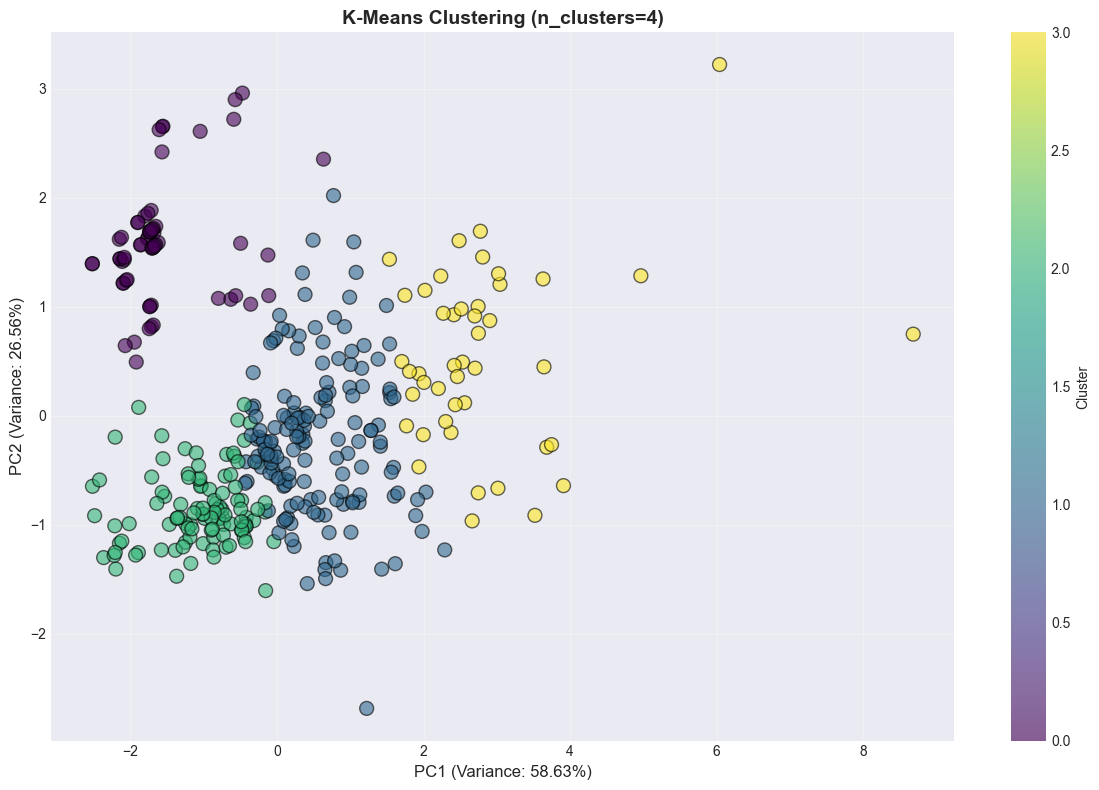

In [66]:
# Visualization clustering với PCA
if len(available_features) > 2:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                        cmap='viridis', s=100, alpha=0.6, edgecolors='black')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 (Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
    plt.ylabel(f'PC2 (Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
    plt.title(f'K-Means Clustering (n_clusters={n_clusters})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, 
                        cmap='viridis', s=100, alpha=0.6, edgecolors='black')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(available_features[0], fontsize=12)
    plt.ylabel(available_features[1], fontsize=12)
    plt.title(f'K-Means Clustering (n_clusters={n_clusters})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [67]:

feature_cols = ['Range', 'TopSpeed', 'Efficiency', 'Acceleration', 
                'FastChargeSpeed', 'NumberofSeats']
available_features_pred = [f for f in feature_cols if f in df.columns]


X = df[available_features_pred].dropna()
y = df.loc[X.index, 'AveragePrice']


valid_mask = (y > 0) & (y < 1000000)  
X = X[valid_mask]
y = y[valid_mask]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [68]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"  Training R²: {train_r2:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Training MAE: {train_mae:.2f}")
print(f"  Test MAE: {test_mae:.2f}")
print(f"  Training RMSE: {train_rmse:.2f}")
print(f"  Test RMSE: {test_rmse:.2f}")


  Training R²: 0.9476
  Test R²: 0.5914
  Training MAE: 5593.10
  Test MAE: 13085.77
  Training RMSE: 8881.92
  Test RMSE: 20161.28


In [69]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': available_features_pred,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance


,Feature,Importance
1,TopSpeed,0.580111
2,Efficiency,0.156465
3,Acceleration,0.119791
4,FastChargeSpeed,0.086576
0,Range,0.050719
5,NumberofSeats,0.006339


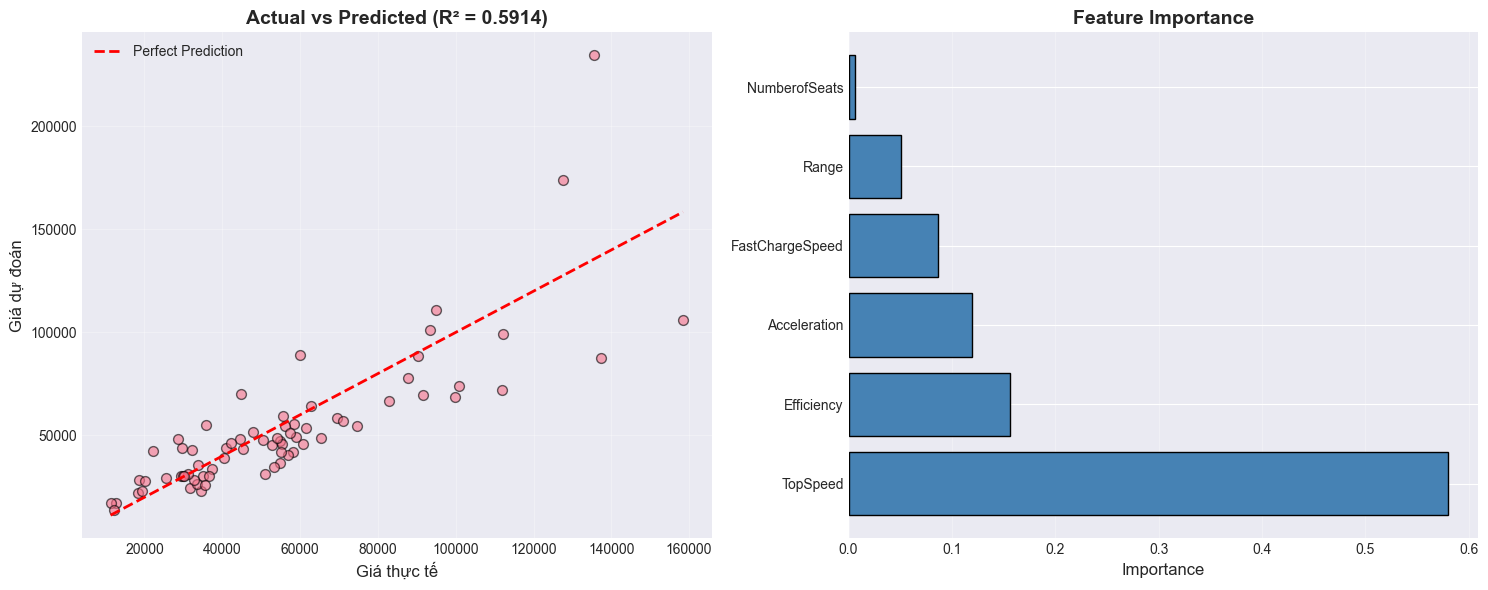

In [70]:
# Visualization 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_test, alpha=0.6, edgecolors='black', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Giá thực tế', fontsize=12)
axes[0].set_ylabel('Giá dự đoán', fontsize=12)
axes[0].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature importance
axes[1].barh(feature_importance['Feature'], feature_importance['Importance'], 
             color='steelblue', edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Feature Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [ ]:

insights = []

if 'Range' in df.columns:
    best_range = df.loc[df['Range'].idxmax()]
    insights.append(f"best_range: {best_range.get('Name', 'N/A')} "
                   f"({best_range['Range']:.0f} km)")

if 'TopSpeed' in df.columns:
    fastest = df.loc[df['TopSpeed'].idxmax()]
    insights.append(f" faster: {fastest.get('Name', 'N/A')} "
                   f"({fastest['TopSpeed']:.0f} km/h)")

if 'RangePerPrice' in df.columns:
    best_value = df.loc[df['RangePerPrice'].idxmax()]
    insights.append(f"(Range/Price): {best_value.get('Name', 'N/A')}")

if 'AveragePrice' in df.columns:
    price_stats = df['AveragePrice'].describe()
    insights.append(f"  - mean_price  {price_stats['mean']:,.0f}")
    insights.append(f"  - min_price {price_stats['min']:,.0f}")
    insights.append(f"  - max_price {price_stats['max']:,.0f}")

# In insights
print("="*60)
for insight in insights:
    print(insight)


best_range: Tesla Roadster  (970 km)
 faster: Tesla Roadster  (410 km/h)
(Range/Price): Mercedes EQE 350+
  - mean_price  51,156
  - min_price 0
  - max_price 375,000
